https://pbpython.com/natural-breaks.html

Installation:
pip install jenkspy
pip install mapclassify ==> pour utiliser scheme dans la fonction plot de geopandas

In [47]:
import geopandas as gpd
import jenkspy
import matplotlib.pyplot as plt
import pandas as pd
import psycopg2

from django.conf import settings
from django.contrib.gis.db.models.functions import AsWKT, AsWKB
from django.db import connection
from django.db.models import F, Sum, DecimalField

from project.models import Project
from public_data.models import Commune, CommuneSol, Cerema

project = Project.objects.filter(name__icontains="Bour").first()
print(project.name)
project.last_year_ocsge

Diagnostic de Bourgogne-Franche-Comté


Diagnostic de Bourgogne-Franche-Comté Diagnostic de CA Bassin d'Arcachon Sud-Pôle Atlantique (COBAS) Diagnostic de CA Grand Auch Cœur de Gascogne Diagnostic de CC Decazeville Communauté Diagnostic de CC de Thann-Cernay Diagnostic de CC de la Forêt Diagnostic de CC du Grand Armagnac Diagnostic de Corse-du-Sud Diagnostic de Grand Est Diagnostic de Meuse Diagnostic de Métropole d'Aix-Marseille-Provence Diagnostic de Ordan-Larroque Diagnostic de Provence-Alpes-Côte d'Azur


In [2]:
pth = gpd.datasets.get_path('naturalearth_lowres')
df = gpd.GeoDataFrame.from_file(pth)
print('Observations, Attributes:',df.shape)
df.head()

Observations, Attributes: (177, 6)


,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,889953.0,Oceania,Fiji,FJI,5496,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,58005463.0,Africa,Tanzania,TZA,63177,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253.0,Africa,W. Sahara,ESH,907,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,37589262.0,North America,Canada,CAN,1736425,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,328239523.0,North America,United States of America,USA,21433226,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


<AxesSubplot:>

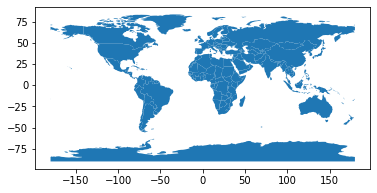

In [3]:
df.plot()

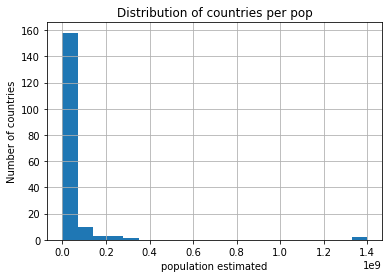

In [4]:
df['pop_est'].hist(bins=20)
plt.xlabel('population estimated')
plt.ylabel('Number of countries')
plt.title('Distribution of countries per pop')
plt.show()

<AxesSubplot:>

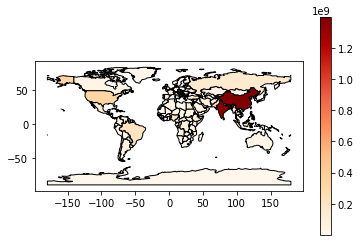

In [5]:
df.plot(column='pop_est', cmap='OrRd', edgecolor='k', legend=True)

<AxesSubplot:>

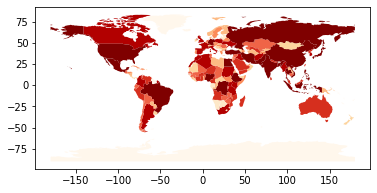

In [6]:
df.plot(column='pop_est', scheme='quantiles', k=9, cmap='OrRd', legend=False)

<AxesSubplot:>

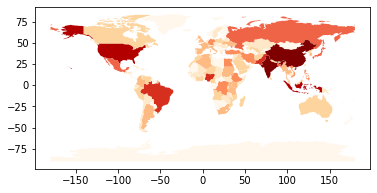

In [7]:
df.plot(column='pop_est', scheme='natural_breaks', k=9, cmap='OrRd', legend=False)

In [8]:
jenkspy.jenks_breaks(df["pop_est"], nb_class=9)

[140.0,
 8082366.0,
 21803000.0,
 39309783.0,
 69625582.0,
 112078730.0,
 163046161.0,
 216565318.0,
 328239523.0,
 1397715000.0]

In [9]:
df['cut_jenksv2'] = pd.cut(df['pop_est'],
                           bins=jenkspy.jenks_breaks(df["pop_est"], nb_class=9),
                           labels=[f"bucket_{i}" for i in range(1,10)],
                           include_lowest=True)
df.sort_values(by=['cut_jenksv2', "pop_est"])

,pop_est,continent,name,iso_a3,gdp_md_est,geometry,cut_jenksv2
23,1.400000e+02,Seven seas (open ocean),Fr. S. Antarctic Lands,ATF,16,"POLYGON ((68.93500 -48.62500, 69.58000 -48.940...",bucket_1
20,3.398000e+03,South America,Falkland Is.,FLK,282,"POLYGON ((-61.20000 -51.85000, -60.00000 -51.2...",bucket_1
159,4.490000e+03,Antarctica,Antarctica,ATA,898,"MULTIPOLYGON (((-48.66062 -78.04702, -48.15140...",bucket_1
22,5.622500e+04,North America,Greenland,GRL,3051,"POLYGON ((-46.76379 82.62796, -43.40644 83.225...",bucket_1
134,2.878000e+05,Oceania,New Caledonia,NCL,10770,"POLYGON ((165.77999 -21.08000, 166.59999 -21.7...",bucket_1
...,...,...,...,...,...,...,...
102,2.165653e+08,Asia,Pakistan,PAK,278221,"POLYGON ((77.83745 35.49401, 76.87172 34.65354...",bucket_7
8,2.706256e+08,Asia,Indonesia,IDN,1119190,"MULTIPOLYGON (((141.00021 -2.60015, 141.01706 ...",bucket_8
4,3.282395e+08,North America,United States of America,USA,21433226,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000...",bucket_8
98,1.366418e+09,Asia,India,IND,2868929,"POLYGON ((97.32711 28.26158, 97.40256 27.88254...",bucket_9


Diagnostic de CA Grand Auch Cœur de Gascogne


2019

In [29]:
qs = (
    CommuneSol.objects.filter(year=project.last_year_ocsge)
    .filter(city__in=project.cities.all())
    .filter(matrix__is_artificial=True)
    .annotate(name=F("city__name"), geom=F("city__mpoly"))
    .values("name", "geom")
    .annotate(indicator=Sum("surface"))
    .values("name", "geom", "indicator")[:100]
)
qs

<QuerySet [{'name': 'Antras', 'geom': <MultiPolygon object at 0x7fede2befc90>, 'indicator': Decimal('17.3000')}, {'name': 'Auch', 'geom': <MultiPolygon object at 0x7fede2befd10>, 'indicator': Decimal('1702.3200')}, {'name': 'Augnax', 'geom': <MultiPolygon object at 0x7fede2befd90>, 'indicator': Decimal('24.2800')}, {'name': 'Auterive', 'geom': <MultiPolygon object at 0x7fede2befe10>, 'indicator': Decimal('93.0300')}, {'name': 'Ayguetinte', 'geom': <MultiPolygon object at 0x7fede2befe90>, 'indicator': Decimal('39.5100')}, {'name': 'Biran', 'geom': <MultiPolygon object at 0x7fede2beff10>, 'indicator': Decimal('127.8400')}, {'name': 'Bonas', 'geom': <MultiPolygon object at 0x7fede2beff90>, 'indicator': Decimal('67.4800')}, {'name': 'Castelnau-Barbarens', 'geom': <MultiPolygon object at 0x7fede2bfe090>, 'indicator': Decimal('157.2200')}, {'name': 'Castillon-Massas', 'geom': <MultiPolygon object at 0x7fede2bfe110>, 'indicator': Decimal('54.9600')}, {'name': 'Castin', 'geom': <MultiPolygon o

In [30]:
sql = qs.query.__str__().replace("::bytea", "")
sql

'SELECT "public_data_commune"."name" AS "name", "public_data_commune"."mpoly" AS "geom", SUM("public_data_communesol"."surface") AS "indicator" FROM "public_data_communesol" INNER JOIN "public_data_commune" ON ("public_data_communesol"."city_id" = "public_data_commune"."id") INNER JOIN "public_data_couvertureusagematrix" ON ("public_data_communesol"."matrix_id" = "public_data_couvertureusagematrix"."id") WHERE ("public_data_communesol"."year" = 2019 AND "public_data_communesol"."city_id" IN (SELECT U0."id" FROM "public_data_commune" U0 INNER JOIN "project_projectcommune" U1 ON (U0."id" = U1."commune_id") WHERE U1."project_id" = 1) AND "public_data_couvertureusagematrix"."is_artificial") GROUP BY "public_data_commune"."name", "public_data_commune"."mpoly" LIMIT 100'

In [33]:
df = gpd.read_postgis(sql, connection)
df

/usr/local/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


,name,geom,indicator
0,Antras,"MULTIPOLYGON (((0.41811 43.73173, 0.41787 43.7...",17.30
1,Auch,"MULTIPOLYGON (((0.48821 43.63911, 0.48838 43.6...",1702.32
2,Augnax,"MULTIPOLYGON (((0.76760 43.71373, 0.76633 43.7...",24.28
3,Auterive,"MULTIPOLYGON (((0.61551 43.57098, 0.61562 43.5...",93.03
4,Ayguetinte,"MULTIPOLYGON (((0.41048 43.81833, 0.41005 43.8...",39.51
5,Biran,"MULTIPOLYGON (((0.38125 43.71196, 0.38201 43.7...",127.84
6,Bonas,"MULTIPOLYGON (((0.38658 43.76623, 0.38617 43.7...",67.48
7,Castelnau-Barbarens,"MULTIPOLYGON (((0.67459 43.57283, 0.67405 43.5...",157.22
8,Castillon-Massas,"MULTIPOLYGON (((0.51344 43.70629, 0.51343 43.7...",54.96
9,Castin,"MULTIPOLYGON (((0.53048 43.67401, 0.53036 43.6...",65.43


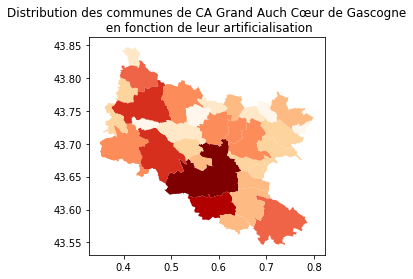

In [39]:
df.plot(column='indicator', scheme='natural_breaks', k=9, cmap='OrRd', legend=False)
plt.title(f'Distribution des communes de {project.get_territory_name()}\n en fonction de leur artificialisation')
plt.show()

In [54]:
# Récupérer les valeurs conso de mon échantillon de commune
fields = Cerema.get_art_field(project.analyse_start_date, project.analyse_end_date)

qs = project.get_cerema_cities()
qs = qs.annotate(conso=sum([F(f) for f in fields]))
qs = qs.values("epci_name")
qs = qs.annotate(conso=Sum(F("conso")))
qs = qs.order_by("epci_name")
print(qs.count())
qs

116


<QuerySet [{'epci_name': 'CA Beaune, Côte et Sud', 'conso': 2384615.0}, {'epci_name': 'CA ECLA  (Espace Communautaire Lons Agglomération)', 'conso': 1453309.0}, {'epci_name': 'CA Grand Belfort', 'conso': 2718159.0}, {'epci_name': 'CA Le Grand Chalon', 'conso': 2868060.0}, {'epci_name': 'CA Moulins Communauté', 'conso': 93681.0}, {'epci_name': 'CA Mâconnais Beaujolais Agglomération', 'conso': 2525294.0}, {'epci_name': 'CA Pays de Montbéliard Agglomération', 'conso': 2671495.0}, {'epci_name': 'CA de Nevers', 'conso': 1076452.0}, {'epci_name': 'CA de Vesoul', 'conso': 864186.0}, {'epci_name': "CA de l'Auxerrois", 'conso': 1666283.0}, {'epci_name': 'CA du Grand Dole', 'conso': 2228050.0}, {'epci_name': 'CA du Grand Sénonais', 'conso': 1723389.0}, {'epci_name': 'CC Altitude 800', 'conso': 555556.0}, {'epci_name': 'CC Amognes Cœur du Nivernais', 'conso': 367291.0}, {'epci_name': 'CC Arbois, Poligny, Salins, Cœur du Jura', 'conso': 1767556.0}, {'epci_name': 'CC Auxonne Pontailler Val de Saône

In [49]:
# Obtenir les ruptures naturelles dans 9 buckets (donc 10 bornes)
jenkspy.jenks_breaks([i['conso'] for i in qs], nb_class=9)

[9843.0,
 222932.0,
 494076.0,
 718302.0,
 1047230.0,
 1389727.0,
 1767556.0,
 2454138.0,
 2868060.0,
 5205836.0]

In [50]:
# Récupérer un dégradé de 9 niveau du plus clair au plus foncé
from utils.colors import get_color_gradient
get_color_gradient(scale=9)[::-1]

[<Color #e5e5ff>,
 <Color #c8c8ff>,
 <Color #acacff>,
 <Color #8f8fff>,
 <Color #7272ff>,
 <Color #5656ff>,
 <Color #3939ff>,
 <Color #1d1dff>,
 <Color blue>]

In [57]:
# Combiner bornes hautes et couleurs:
import json
json.dumps(
    [
        {'value': v, 'color': c.hex_l}
        for v, c in
        zip(
            jenkspy.jenks_breaks([i['conso'] for i in qs], nb_class=9)[1:],
            get_color_gradient(scale=9)[::-1]
        )
    ]
)

'[{"value": 222932.0, "color": "#e5e5ff"}, {"value": 494076.0, "color": "#c8c8ff"}, {"value": 718302.0, "color": "#acacff"}, {"value": 1047230.0, "color": "#8f8fff"}, {"value": 1389727.0, "color": "#7272ff"}, {"value": 1767556.0, "color": "#5656ff"}, {"value": 2454138.0, "color": "#3939ff"}, {"value": 2868060.0, "color": "#1d1dff"}, {"value": 5205836.0, "color": "#0000ff"}]'